In [70]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from scipy.io import loadmat
import scipy.signal as sp

In [15]:
data_path = "/Volumes/DATA/nanosphere_data"

data_folders = ['20240724_minus_one_e_data/20240724_150v_1_8e-8mbar',]

In [21]:
combined_path = os.path.join(data_path, data_folders[0], '**/*.mat')
data_files = glob.glob(combined_path, recursive=True)

In [83]:
for data_file in data_files[:1]:
    data = loadmat(data_file)

    sphere_z = np.ndarray.flatten(data['D'])
    drive = np.ndarray.flatten(data['G'])
    time = np.arange(0, len(sphere_z)*data['Tinterval'], data['Tinterval'])
 


/var/folders/35/ft5fljg94_x6xpzhzn_wtctr0000gn/T/ipykernel_30469/2211610048.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  time = np.arange(0, len(sphere_z)*data['Tinterval'], data['Tinterval'])


In [121]:
f, zpsd = sp.welch(sphere_z, fs=1/data['Tinterval'][0], nperseg=2**16)

(8.4690555e-14, 0.00017371825)

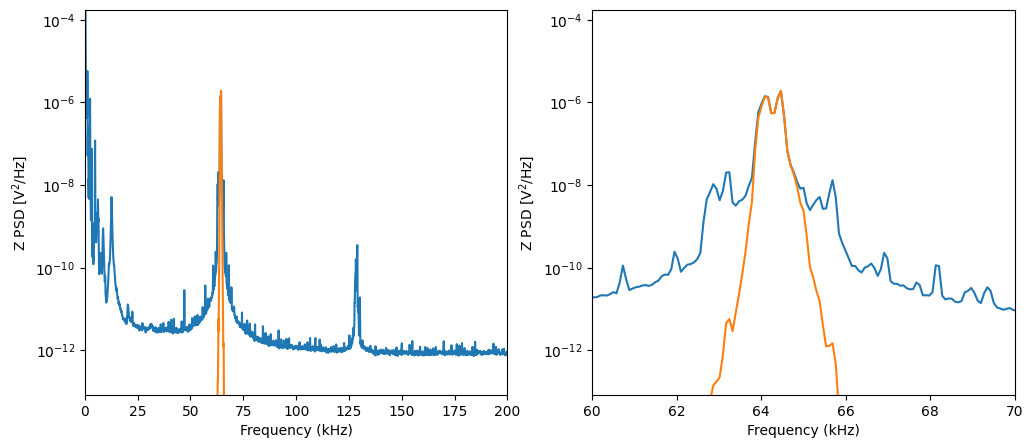

In [131]:
hz_to_khz = 1e-3

peak_location = [63.8e3, 65e3]
b, a = sp.butter(3, peak_location, btype='bandpass', fs=1/data['Tinterval'][0])
filtered_data = sp.filtfilt(b, a, sphere_z)

f_filt, zpsd_filt = sp.welch(filtered_data, fs=1/data['Tinterval'][0], nperseg=2**16)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.semilogy(f*hz_to_khz, zpsd)
plt.semilogy(f_filt*hz_to_khz, zpsd_filt)
plt.xlim(0, 200)
plt.xlabel("Frequency (kHz)")
plt.ylabel("Z PSD [V$^2$/Hz]")
plt.ylim(np.min(zpsd), np.max(zpsd))

plt.subplot(1,2,2)
plt.semilogy(f*hz_to_khz, zpsd)
plt.semilogy(f_filt*hz_to_khz, zpsd_filt)
plt.xlim(60, 70)
plt.xlabel("Frequency (kHz)")
plt.ylabel("Z PSD [V$^2$/Hz]")
plt.ylim(np.min(zpsd), np.max(zpsd))

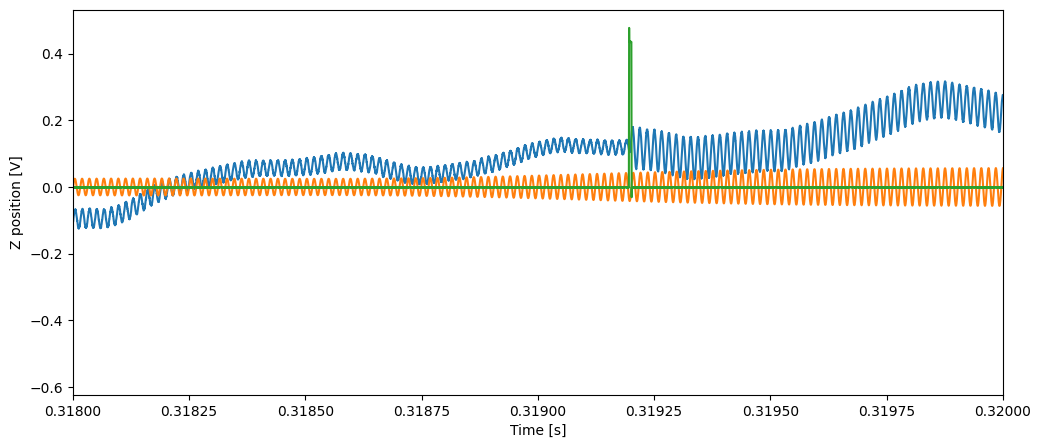

In [142]:
plt.figure(figsize=(12,5))
plt.plot(time, sphere_z)
plt.plot(time, filtered_data)
plt.plot(time, data['G']/np.max(data['G'])* np.max(sphere_z))
plt.xlim([np.min(time), np.max(time)])
#plt.xlim([0.01917,0.01925])
plt.xlim([0.318,0.32])
plt.xlabel("Time [s]")
plt.ylabel("Z position [V]")
plt.show()